The beginning of our notebook on reproducing and showcasing the Speculative decoding paper.

## Example Demo

### Model Setup

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import time
import sys
import torch
checkpoint = "openai-community/gpt2-large"
assistant_checkpoint = "openai-community/gpt2"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
target_model = AutoModelForCausalLM.from_pretrained(checkpoint)
draft_model = AutoModelForCausalLM.from_pretrained(assistant_checkpoint)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

### Standard Decoding

In [2]:
def standard_decoding(prompt, model, tokenizer, tokens=20, delay=0.1):
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    generated = input_ids.clone()
    sys.stdout.write(prompt)
    sys.stdout.flush()
    stat = []
    for _ in range(tokens):
        start = time.time()
        next_token = model.generate(generated, max_new_tokens=1, do_sample=False, pad_token_id=tokenizer.eos_token_id)[:, generated.shape[1]:]
        next_char = tokenizer.decode(next_token[0], skip_special_tokens=True)
        end = time.time()
        stat.append((next_char, end - start))
        sys.stdout.write(f"\033[92m{next_char}\033[0m")
        sys.stdout.flush()

        generated = torch.cat([generated, next_token.reshape(1,1)], dim=1)
        time.sleep(delay)

        if next_token == tokenizer.eos_token_id:
            break
    total_execution_time = sum([x[1] for x in stat])
    print()
    for data in stat:
        print(f"{data[0]}:\t{data[1]:.2f}")
    print(f"\nTotal execution time: {total_execution_time:.2f} seconds")

### Speculative Decoding

#### Prediction Stage

In [3]:
def draft_tokens(draft_model, input_ids, max_new_tokens=5):
    draft_ids = draft_model.generate(
        input_ids,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id
    )[:, input_ids.shape[1]:]
    draft_text = tokenizer.decode(draft_ids[0], skip_special_tokens=True)
    return draft_ids, draft_text

#### Verification Stage

In [4]:
def verify_tokens(target_model, generated, draft_ids):
    combined = torch.cat([generated, draft_ids], dim=1)
    logits = target_model(combined).logits
    verified = []
    for i in range(draft_ids.shape[1]):
        original_idx = generated.shape[1] - 1 + i
        if original_idx >= logits.shape[1]:
            break

        target_token = logits[0, original_idx].argmax()
        if target_token == draft_ids[0, i]:
            verified.append(target_token.item())
        else:
            break
    return verified, logits

#### Additional Sampling

In [5]:
def additional_sampling(target_model, generated, draft_ids, verified, logits, show_internal_step=False, max_tokens=20):
    if len(verified) < draft_ids.shape[1]:
        next_token = logits[0, generated.shape[1]-1].argmax()
        next_char = tokenizer.decode([next_token], skip_special_tokens=True)
        if show_internal_step:
            sys.stdout.write(f"\033[91m{next_char}\033[0m\n")
            sys.stdout.flush()
        generated = torch.cat([generated, next_token.reshape(1,1)], dim=1)
        return next_char, generated
    else:
        next_char = ""
        if generated.shape[1] >= max_tokens:
            sys.stdout.write(f"\n")
            sys.stdout.flush()
            return "", generated
        else:
            next_token = target_model.generate(generated, max_new_tokens=1, do_sample=False, pad_token_id=tokenizer.eos_token_id)[:, generated.shape[1]:]
            next_char = tokenizer.decode(next_token[0], skip_special_tokens=True)
            generated = torch.cat([generated, next_token.reshape(1,1)], dim=1)
            if show_internal_step:
                sys.stdout.write(f"\033[94m{next_char}\033[0m\n")
                sys.stdout.flush()
            return next_char, generated

#### Put Together

In [6]:
def speculative_decoding(prompt, model, draft_model, tokenizer, tokens=20, delay=0.1, gamma=5, show_internal_step=True):
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    generated = input_ids.clone()
    total_tokens = generated.shape[1] + tokens
    draft_length = gamma
    stat = []
    if show_internal_step:
        print(prompt)
    else:
        sys.stdout.write(prompt)
        sys.stdout.flush()
    while generated.shape[1] < total_tokens:
        # Measure draft time
        start = time.time()
        stride = min(gamma, abs(total_tokens - generated.shape[1]))
        draft_ids, draft_text = draft_tokens(draft_model, generated, max_new_tokens=stride)
        end = time.time()
        draft_time = end - start
        # Print draft tokens
        if show_internal_step:
            sys.stdout.write(f"\033[90m{draft_text}\033[0m\n")
            sys.stdout.flush()

        # Measure verification time
        start = time.time()
        verified, logits = verify_tokens(model, generated, draft_ids)
        end = time.time()
        verification_time = end - start
        #Print Verified Token
        verified_text = ""
        if verified:
            verified_text = tokenizer.decode(verified, skip_special_tokens=True)
            if show_internal_step:
                sys.stdout.write(f"\033[92m{verified_text}\033[0m")
                sys.stdout.flush()
            generated = torch.cat([generated, torch.tensor([verified])], dim=1)

        # Measure time on additional sampling
        start = time.time()
        next_char, generated = additional_sampling(model, generated, draft_ids, verified, logits, show_internal_step, total_tokens)
        end = time.time()
        sample_time = end - start
        stat.append((verified_text + next_char, draft_time + verification_time+sample_time))
        if show_internal_step is False:
            sys.stdout.write(f"\033[92m{verified_text + next_char}\033[0m")
            sys.stdout.flush()
        else:
            print("".join([prompt] + [x[0] for x in stat]))

        time.sleep(delay)
    print()
    for data in stat:
        print(f"{data[0]}:\t{data[1]:.2f}")
    total_execution_time = sum([x[1] for x in stat])
    print(f"Total execution time: {total_execution_time:.2f} seconds")

### Demo

In [7]:
prompt = "CSC2541 is a course about"

In [8]:
standard_decoding(prompt, target_model, tokenizer, 15)

CSC2541 is a course about

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


 the history of the United States and the United States' role in the world
 the:	0.90
 history:	0.69
 of:	0.70
 the:	0.69
 United:	0.71
 States:	0.73
 and:	0.73
 the:	1.08
 United:	1.04
 States:	0.99
':	0.78
 role:	0.85
 in:	0.93
 the:	1.02
 world:	0.82

Total execution time: 12.66 seconds


In [9]:
speculative_decoding(prompt, target_model, draft_model, tokenizer, 15, show_internal_step=False)

CSC2541 is a course about the history of the United States and the United States'
 role in the world
 the history of the United States:	1.83
 and the:	1.22
 United:	1.17
 States':	1.19
 role in the world:	1.14
Total execution time: 6.55 seconds


In [10]:
speculative_decoding(prompt, target_model, draft_model, tokenizer, 15, show_internal_step=True)

CSC2541 is a course about
 the history of the United
 the history of the United States
CSC2541 is a course about the history of the United States
 and its relationship with the
 and the
CSC2541 is a course about the history of the United States and the
 role of the United States
 United
CSC2541 is a course about the history of the United States and the United
 States Constitution. It is
 States'
CSC2541 is a course about the history of the United States and the United States'
 role in the world
 role in the world
CSC2541 is a course about the history of the United States and the United States' role in the world

 the history of the United States:	1.84
 and the:	1.37
 United:	1.40
 States':	1.15
 role in the world:	1.14
Total execution time: 6.90 seconds


## Benchmarks

### Setup

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
from tqdm.notebook import tqdm

### Decoding benchmark

In [12]:
def benchmark_decoding(prompt, model, draft_model, tokenizer, tokens=50, gamma_values=[1, 2, 4, 6, 8, 10], temperature_values=[0.0, 0.4, 0.8, 1.0]):
    """
    Benchmark speculative decoding across different gamma values and temperature settings
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = model.to(device)
    draft_model = draft_model.to(device)

    results = []

    print("Benchmarking standard decoding...")
    for temp in tqdm(temperature_values):
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        start_time = time.time()

        input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
        generated = input_ids.clone()

        for _ in range(tokens):
            if temp == 0.0:
                next_token = model.generate(
                    generated,
                    max_new_tokens=1,
                    do_sample=False,
                    pad_token_id=tokenizer.eos_token_id
                )[:, generated.shape[1]:]
            else:
                next_token = model.generate(
                    generated,
                    max_new_tokens=1,
                    do_sample=True,
                    temperature=temp,
                    pad_token_id=tokenizer.eos_token_id
                )[:, generated.shape[1]:]

            generated = torch.cat([generated, next_token.reshape(1,1)], dim=1)

            if next_token.item() == tokenizer.eos_token_id:
                break

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        end_time = time.time()
        execution_time = end_time - start_time
        tokens_generated = generated.shape[1] - input_ids.shape[1]
        tokens_per_second = tokens_generated / execution_time

        results.append({
            'method': 'standard',
            'gamma': 'n/a',
            'temperature': temp,
            'execution_time': execution_time,
            'tokens_generated': tokens_generated,
            'tokens_per_second': tokens_per_second,
            'acceptance_rate': 'n/a'
        })

        print(f"Standard decoding (T={temp}): {tokens_per_second:.2f} tokens/sec")

    print("\nBenchmarking speculative decoding...")
    for gamma in tqdm(gamma_values):
        for temp in temperature_values:
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            start_time = time.time()
            input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
            generated = input_ids.clone()
            total_tokens = input_ids.shape[1] + tokens

            total_draft_tokens = 0
            total_accepted_tokens = 0

            while generated.shape[1] < total_tokens:
                stride = min(gamma, total_tokens - generated.shape[1])

                if temp == 0.0:
                    draft_ids = draft_model.generate(
                        generated,
                        max_new_tokens=stride,
                        do_sample=False,
                        pad_token_id=tokenizer.eos_token_id
                    )[:, generated.shape[1]:]
                else:
                    draft_ids = draft_model.generate(
                        generated,
                        max_new_tokens=stride,
                        do_sample=True,
                        temperature=temp,
                        pad_token_id=tokenizer.eos_token_id
                    )[:, generated.shape[1]:]

                draft_count = draft_ids.shape[1]
                total_draft_tokens += draft_count

                if draft_count == 0:
                    break

                verified, logits = verify_tokens(model, generated, draft_ids)
                verified_count = len(verified)
                total_accepted_tokens += verified_count

                if verified:
                    verified_tensor = torch.tensor([verified], device=device)
                    generated = torch.cat([generated, verified_tensor], dim=1)

                if verified_count < draft_count:
                    next_token = logits[0, generated.shape[1]-1].argmax().reshape(1, 1)
                    generated = torch.cat([generated, next_token], dim=1)
                    total_accepted_tokens += 1

                if generated.shape[1] >= total_tokens:
                    break

            if torch.cuda.is_available():
                torch.cuda.synchronize()

            end_time = time.time()
            execution_time = end_time - start_time
            tokens_generated = generated.shape[1] - input_ids.shape[1]
            tokens_per_second = tokens_generated / execution_time
            acceptance_rate = total_accepted_tokens / total_draft_tokens if total_draft_tokens > 0 else 0

            results.append({
                'method': 'speculative',
                'gamma': gamma,
                'temperature': temp,
                'execution_time': execution_time,
                'tokens_generated': tokens_generated,
                'tokens_per_second': tokens_per_second,
                'acceptance_rate': acceptance_rate
            })

            print(f"Speculative (γ={gamma}, T={temp}): {tokens_per_second:.2f} tokens/sec, acceptance rate: {acceptance_rate:.2f}")

    return pd.DataFrame(results)

### Plot Results

In [13]:
def plot_benchmark_results(results):
    """
    Create visualizations from the benchmark results
    """
    standard_results = results[results['method'] == 'standard'].copy()
    standard_results['speedup'] = 1.0  # Baseline has speedup of 1

    spec_results = results[results['method'] == 'speculative'].copy()

    for temp in spec_results['temperature'].unique():
        baseline_tps = standard_results[standard_results['temperature'] == temp]['tokens_per_second'].values[0]
        spec_results.loc[spec_results['temperature'] == temp, 'speedup'] = spec_results.loc[spec_results['temperature'] == temp, 'tokens_per_second'] / baseline_tps

    # 1. Plot speedup across different gamma values for each temperature
    plt.figure(figsize=(12, 8))

    for temp in spec_results['temperature'].unique():
        temp_data = spec_results[spec_results['temperature'] == temp]
        plt.plot(temp_data['gamma'], temp_data['speedup'], 'o-', label=f'T={temp}')

    plt.axhline(y=1.0, color='r', linestyle='--', label='Baseline (Standard Decoding)')
    plt.xlabel('Gamma (Draft tokens)')
    plt.ylabel('Speedup')
    plt.title('Speculative Decoding Speedup vs. Gamma')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # 2. Plot acceptance rate across different gamma values for each temperature
    plt.figure(figsize=(12, 8))

    for temp in spec_results['temperature'].unique():
        temp_data = spec_results[spec_results['temperature'] == temp]
        plt.plot(temp_data['gamma'], temp_data['acceptance_rate'], 'o-', label=f'T={temp}')

    plt.xlabel('Gamma (Draft tokens)')
    plt.ylabel('Acceptance Rate')
    plt.title('Acceptance Rate vs. Gamma')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # 3. Plot speedup vs acceptance rate scatter
    plt.figure(figsize=(10, 8))

    for temp in spec_results['temperature'].unique():
        temp_data = spec_results[spec_results['temperature'] == temp]
        plt.scatter(temp_data['acceptance_rate'], temp_data['speedup'], label=f'T={temp}', s=100)

        for _, row in temp_data.iterrows():
            plt.annotate(f"γ={int(row['gamma'])}",
                        (row['acceptance_rate'], row['speedup']),
                        xytext=(5, 5), textcoords='offset points')

    plt.axhline(y=1.0, color='r', linestyle='--', label='Baseline')
    plt.xlabel('Acceptance Rate')
    plt.ylabel('Speedup')
    plt.title('Speedup vs. Acceptance Rate')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

### Running the benchmarks

In [14]:
test_prompts = [
    "The quickest way to double your money is to",
    "Climate change is affecting the planet in several ways including",
    "Artificial intelligence has transformed many industries by",
    "The relationship between technology and society is",
    "The most important scientific discovery of the last century was"
]

In [15]:
benchmark_prompt = test_prompts[0]
print(f"Using prompt: '{benchmark_prompt}'")

Using prompt: 'The quickest way to double your money is to'


In [16]:
results_df = benchmark_decoding(
    benchmark_prompt,
    target_model,
    draft_model,
    tokenizer,
    tokens=25,
    gamma_values=[1, 2, 4, 6, 8],
    temperature_values=[0.0, 0.25, 0.5, 0.75, 1.0]
)

Using device: cuda
Benchmarking standard decoding...


  0%|          | 0/5 [00:00<?, ?it/s]

Standard decoding (T=0.0): 17.67 tokens/sec
Standard decoding (T=0.25): 25.42 tokens/sec
Standard decoding (T=0.5): 33.85 tokens/sec
Standard decoding (T=0.75): 34.19 tokens/sec
Standard decoding (T=1.0): 35.70 tokens/sec

Benchmarking speculative decoding...


  0%|          | 0/5 [00:00<?, ?it/s]

Speculative (γ=1, T=0.0): 19.86 tokens/sec, acceptance rate: 1.00
Speculative (γ=1, T=0.25): 17.26 tokens/sec, acceptance rate: 1.00
Speculative (γ=1, T=0.5): 17.84 tokens/sec, acceptance rate: 1.00
Speculative (γ=1, T=0.75): 21.10 tokens/sec, acceptance rate: 1.00
Speculative (γ=1, T=1.0): 22.12 tokens/sec, acceptance rate: 1.00
Speculative (γ=2, T=0.0): 28.72 tokens/sec, acceptance rate: 0.86
Speculative (γ=2, T=0.25): 29.39 tokens/sec, acceptance rate: 0.86
Speculative (γ=2, T=0.5): 27.83 tokens/sec, acceptance rate: 0.81
Speculative (γ=2, T=0.75): 25.35 tokens/sec, acceptance rate: 0.71
Speculative (γ=2, T=1.0): 25.09 tokens/sec, acceptance rate: 0.71
Speculative (γ=4, T=0.0): 38.62 tokens/sec, acceptance rate: 0.76
Speculative (γ=4, T=0.25): 38.55 tokens/sec, acceptance rate: 0.74
Speculative (γ=4, T=0.5): 29.80 tokens/sec, acceptance rate: 0.60
Speculative (γ=4, T=0.75): 19.11 tokens/sec, acceptance rate: 0.47
Speculative (γ=4, T=1.0): 14.61 tokens/sec, acceptance rate: 0.46
Spec

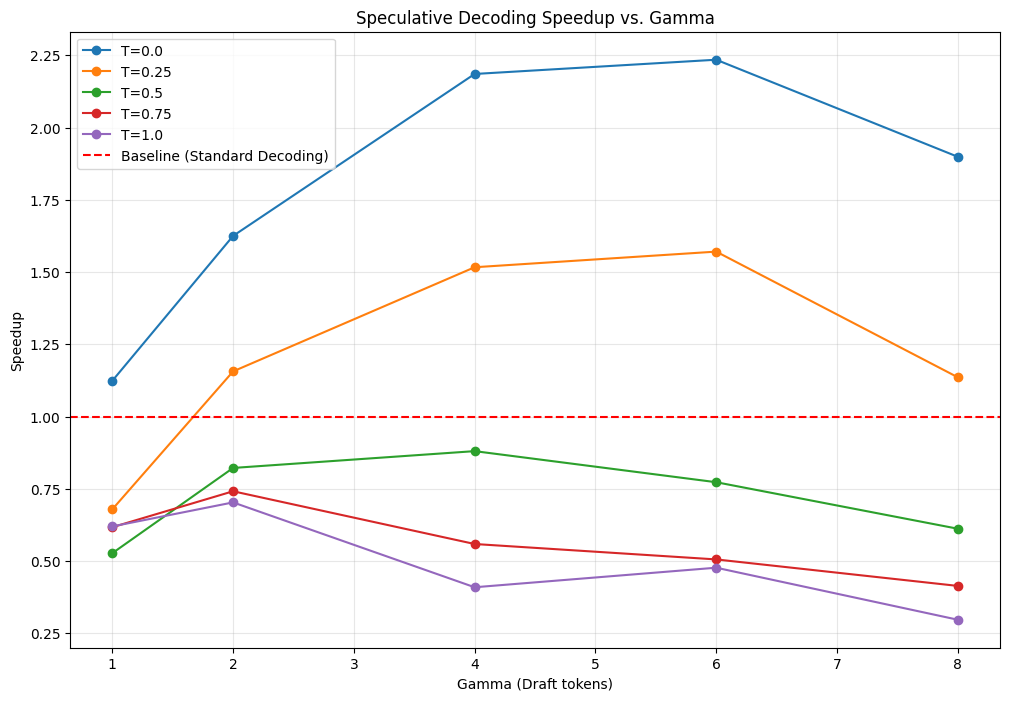

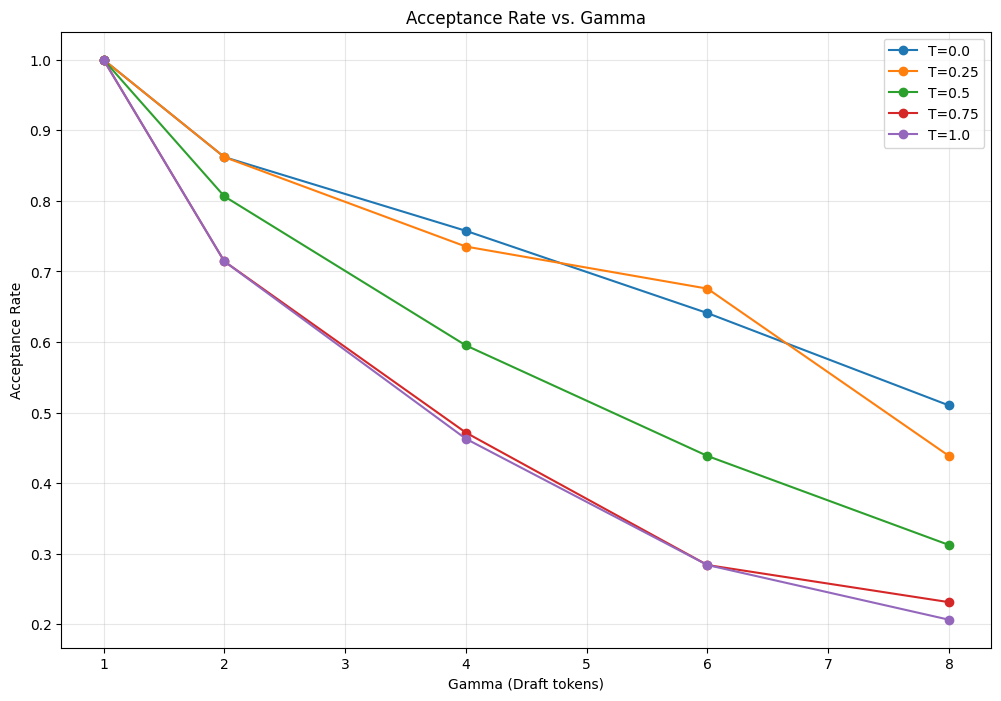

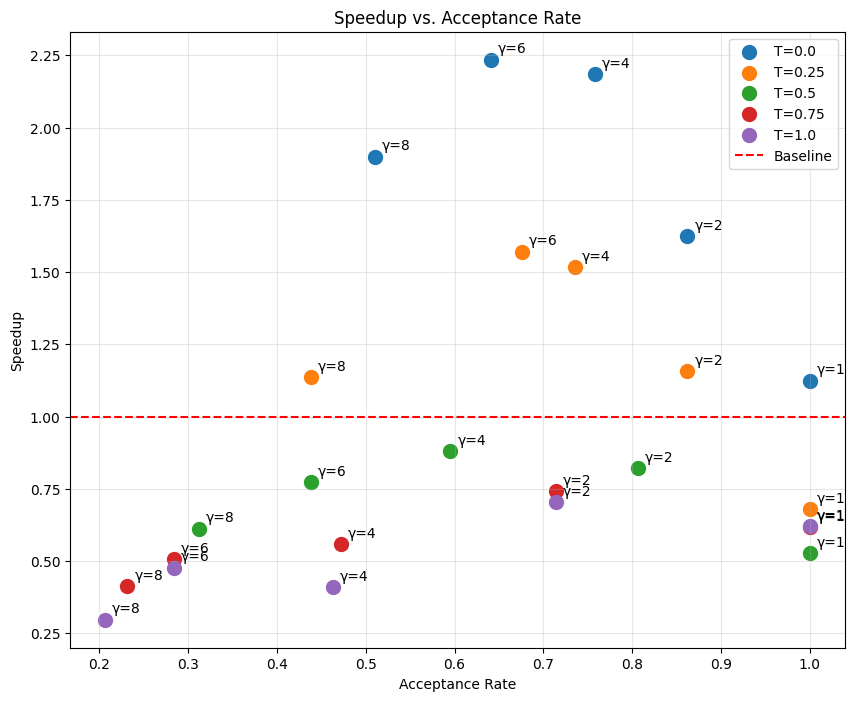

In [17]:
plot_benchmark_results(results_df)